## Classifying Duplicate Questions with TensorFlow

This notebook details the approach in using Convolutional Neural Networks in TensorFlow to train a model to learn how to identify duplicate questions.

In [1]:
%matplotlib inline

import os
# set to your working directory
path = '/Users/ianlo/Documents/Data Analyitcs & Data Science/TensorFlow/Duplicate_Questions/'
os.chdir(path)

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import gc
import seaborn as sns
import scipy as scipy
import scipy.ndimage
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import nltk

from sklearn.preprocessing import OneHotEncoder
from sklearn.cross_validation import train_test_split
from sklearn import preprocessing
from multiprocessing import cpu_count

# customised imports
import global_settings as gs

# initialise global parameters
gs.init()
pal = sns.color_palette()

# set no of groups for partitioning
_number_of_groups = int(cpu_count()*0.8)

# set no of threads
_cpu = int(cpu_count()*0.8)

/Users/ianlo/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Exploratory Data Analysis

Load training data for EDA

Total number of question pairs for training: 404290
Total number of duplicate question pairs: 36.92%
Total number of questions in the training data: 537933
Number of questions that appear multiple times: 111780



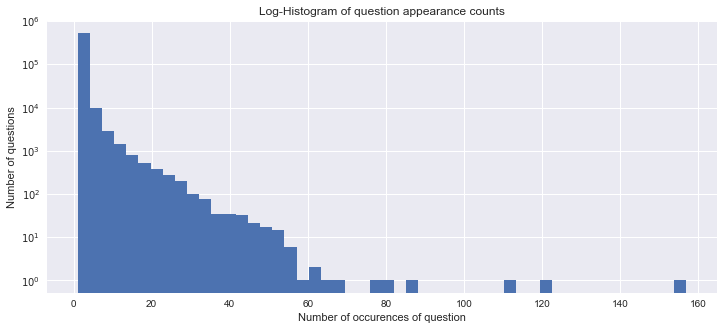

In [2]:
# import training data as dataframe 
df_train = pd.read_csv('./train.csv')

print('Total number of question pairs for training: {}'.format(len(df_train)))
# no of positive training examples
print('Total number of duplicate question pairs: {}%'.format(round(df_train['is_duplicate'].mean() * 100,2)))

qids = pd.Series(df_train['qid1'].tolist() + df_train['qid2'].tolist())
print('Total number of questions in the training data: {}'.format(len(np.unique(qids))))
# Any duplicate questions in the list?
print('Number of questions that appear multiple times: {}'.format(np.sum(qids.value_counts() > 1)))

# plot the histogram of the no. of questions that appear multiple times
plt.figure(figsize=(12, 5))
plt.hist(qids.value_counts(), bins=50)
plt.yscale('log', nonposy='clip')
plt.title('Log-Histogram of question appearance counts')
plt.xlabel('Number of occurences of question')
plt.ylabel('Number of questions')
print()

#### Visualise the word distribution

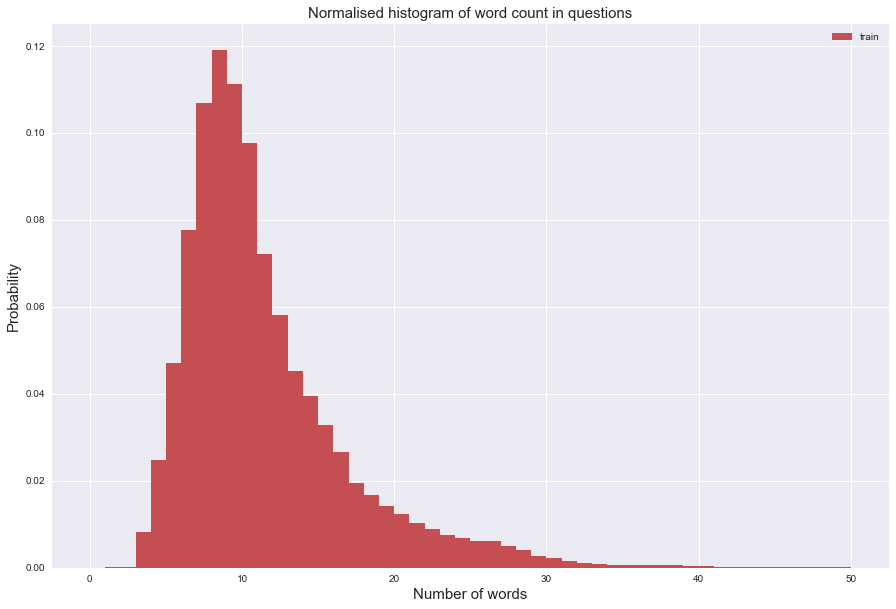

In [3]:
# start looking at the questions
# get all the questions from the train dataset
train_qs = pd.Series(df_train['question1'].tolist() + df_train['question2'].tolist()).astype(str)

# get the counts of words for each question in in the training and test set
dist_train = train_qs.apply(lambda x: len(x.split(' ')))

plt.figure(figsize=(15, 10))
plt.hist(dist_train, bins=50, range=[0, 50], color=pal[2], normed=True, label='train')
plt.title('Normalised histogram of word count in questions', fontsize=15)
plt.legend()
plt.xlabel('Number of words', fontsize=15)
plt.ylabel('Probability', fontsize=15)
print()

# free up memory
del [dist_train]

## Data Cleansing & Pre-Processing

The following pre-processing is done on the training dataset
- Replace apostrophes with its full term e.g re.sub(r"what's", "what is ", text)
- Remove punctuations
- Substitute 'K' with corresponding number e.g. 10K = 10000
- Remove stopwords (except for specific whitelisted e.g. How, Why, When etc ..)
- Stemming to identify common root words

## Load Pre-built Training Data

In [4]:
# import training data as dataframe 
df_train = pd.read_csv('./df_all_temp_pres.csv')

df_train.head()

,grpId,id,qid1,qid2,is_duplicate,q1nopunct,q2nopunct,q1nopunct_stem,q2nopunct_stem,tr_q1WrdCnt,...,tr_q1Len_zscore,wrdmatchpct,tr_q2Len_zscore,test_id,sem_similarity,word_order_similarity,weight_q1_sw,weight_q2_sw,weight_q1_mw,weight_q2_mw
0,0,337140,464581,464582,0,how good is mercedes benz in india,what is it like to work for mercedes benz in i...,"['good', 'merced', 'benz', 'in', 'india']",like work mercedes benz in india,8,...,-0.819746,0.72727,-0.257769,-9999,0.753482,0.600540,2.494043,2.808815,0.356292,0.312091
1,0,84666,143117,143118,0,if i wanted to get a hair transplant without a...,what is the price of a hair transplant in indi...,"['want', 'get', 'hair', 'transplant', 'without...",price hair transplant in india does work there...,26,...,2.390467,0.22222,0.853626,-9999,0.493243,0.333799,4.362126,3.392260,0.207720,0.260943
2,0,90276,151518,72769,0,what are the pictures that made you look twice,what are some amazing pictures one has to see ...,"['pictur', 'made', 'look', 'twice']",some amazing pictures one has see twice unders...,10,...,-0.409932,0.33333,0.192797,-9999,0.599406,0.477551,2.128451,2.574873,0.425690,0.367839
3,0,135174,215923,57862,1,why does quora allow allow some users to disab...,why does quora allow people to turn off comments,"['why', 'does', 'quora', 'allow', 'some', 'use...",why does quora allow people turn off comments,11,...,0.034034,0.50000,-0.317844,-9999,0.625000,0.690649,3.293738,3.134032,0.274478,0.284912
4,0,47724,85180,85181,0,what are some famous stories about tamil actre...,how many telugu stars are famous in tamil,"['some', 'famous', 'stori', 'about', 'tamil', ...",many telugu stars famous in tamil,11,...,0.204790,0.28571,-0.528108,-9999,0.503819,0.340515,3.226857,2.875142,0.293351,0.319460


In [5]:
df_train.ix[1]

grpId                                                                    0
id                                                                   84666
qid1                                                                143117
qid2                                                                143118
is_duplicate                                                             0
q1nopunct                if i wanted to get a hair transplant without a...
q2nopunct                what is the price of a hair transplant in indi...
q1nopunct_stem           ['want', 'get', 'hair', 'transplant', 'without...
q2nopunct_stem           price hair transplant in india does work there...
tr_q1WrdCnt                                                             26
tr_q2WrdCnt                                                             18
tr_q1Len                                                               129
tr_q2Len                                                                88
type                     

Because the data cleansing and feature creation takes sometime, I have created a H5 file of the processed data set for ease of use.

In [6]:
##############################################################################
# Load pre-built training sets
##############################################################################

# Read the training and test set from HDFStore
trn = pd.DataFrame()

tr_store = pd.HDFStore('df_all_train_pres.h5')
nrows = tr_store.get_storer('df').nrows

#for chunk in pd.read_hdf('df_all_intermediate.h5','df', chunksize=chunksize, where='type = "TR"'):
for i in range(nrows//gs.chunksize + 1):
    chunk = tr_store.select('df', start=i * gs.chunksize, stop=(i+1) * gs.chunksize)
    trn = trn.append(chunk.loc[chunk['type'] == 'TR'])
    print("Finished reading", str(i), "chunks")

    del chunk
    
tr_store.close()

# garbage collection
gc.collect()

# remove unwanted columns from the pre-processed training data set
trn.drop(['grpId',
          'id',
          'type',
          'test_id',
          'tr_q1WrdCnt_zscore',
          'tr_q2WrdCnt_zscore',
          'tr_q1Len_zscore',
          'tr_q2Len_zscore'
          ], axis=1, inplace = True)

# move label to the last column for ease of viewing
trn = trn[[col for col in trn if col != 'is_duplicate'] + ['is_duplicate']]

# during the gen_semantic_similarity and gen_word_order_similarity there could
# have been null / NA values - hence need to set the value to 0.0
trn.loc[trn.word_order_similarity.isnull(), 'word_order_similarity'] = 0.0

# during the generation of the tfidf weight matrix there could
# have been null / NA values - hence need to set the value to 0.0
trn.loc[trn.weight_q1_sw.isnull(), 'weight_q1_sw'] = 0.0
trn.loc[trn.weight_q2_sw.isnull(), 'weight_q2_sw'] = 0.0
trn.loc[trn.weight_q1_mw.isnull(), 'weight_q1_mw'] = 0.0
trn.loc[trn.weight_q2_mw.isnull(), 'weight_q2_mw'] = 0.0

# set the column names of the data frame as str for easier referencing
trn.columns = trn.columns.astype(str)

# inspect the loaded data
trn.head()

/Users/ianlo/anaconda/lib/python3.6/site-packages/tables/leaf.py:394: PerformanceWarning: The Leaf ``/df/_i_table/type/sorted`` is exceeding the maximum recommended rowsize (104857600 bytes);
be ready to see PyTables asking for *lots* of memory and possibly slow
I/O.  You may want to reduce the rowsize by trimming the value of
dimensions that are orthogonal (and preferably close) to the *main*
dimension of this leave.  Alternatively, in case you have specified a
very small/large chunksize, you may want to increase/decrease it.
  PerformanceWarning)


Finished reading 0 chunks
Finished reading 1 chunks
Finished reading 2 chunks
Finished reading 3 chunks
Finished reading 4 chunks


,tr_q1WrdCnt,tr_q2WrdCnt,tr_q1Len,tr_q2Len,wrdmatchpct,sem_similarity,word_order_similarity,weight_q1_sw,weight_q2_sw,weight_q1_mw,...,775,776,777,778,779,780,781,782,783,is_duplicate
0,8,12,35,51,0.72727,0.753482,0.600540,2.494043,2.808815,0.356292,...,0.07321,0.07321,0.07321,0.45836,0.45836,0.45836,0.45836,0.33885,0.33885,0
6,11,33,49,156,0.37037,0.564745,0.405881,2.553065,4.759111,0.364724,...,0.11908,0.17593,0.17593,0.17229,0.17229,0.27285,0.00000,0.00000,0.12707,0
12,13,19,68,104,0.26667,0.235702,0.331658,1.403321,3.211078,0.701660,...,0.29930,0.29930,0.13056,0.13056,0.32244,0.32244,0.00000,0.00000,0.27620,0
18,12,14,54,64,0.50000,0.725194,0.416087,2.551618,3.152514,0.364517,...,0.07559,0.07559,0.10187,0.10187,0.10187,0.04777,0.04777,0.68204,0.68204,1
24,17,17,85,97,0.40000,0.560983,0.706114,3.173274,3.559861,0.288479,...,0.21228,0.21228,0.11248,0.11248,0.00000,0.00000,0.13997,0.13997,0.11248,0


### Label distribution over wrdmatchpct

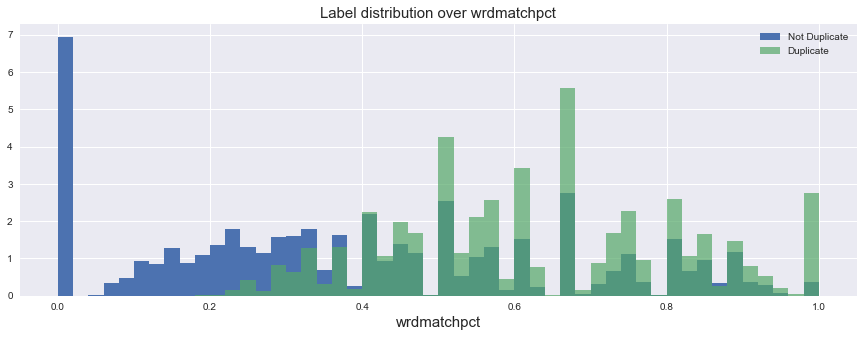

In [7]:
plt.figure(figsize=(15, 5))
train_word_match = trn['wrdmatchpct']
plt.hist(train_word_match[trn['is_duplicate'] == 0], bins=50, normed=True, label='Not Duplicate')
plt.hist(train_word_match[trn['is_duplicate'] == 1], bins=50, normed=True, alpha=0.7, label='Duplicate')
plt.legend()
plt.title('Label distribution over wrdmatchpct', fontsize=15)
plt.xlabel('wrdmatchpct', fontsize=15)

### Label distribution over word_order_similarity

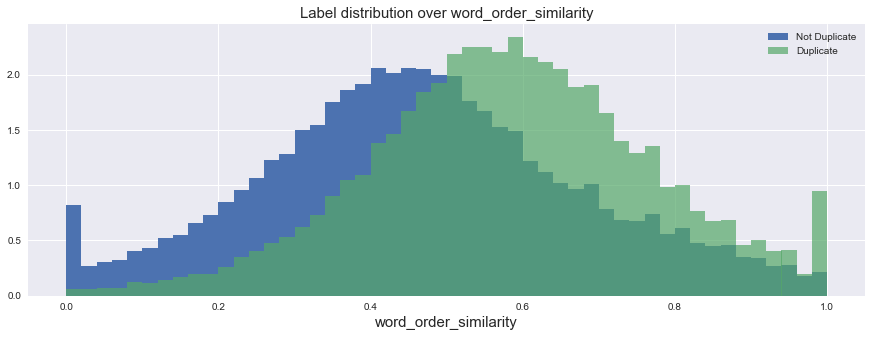

In [8]:
plt.figure(figsize=(15, 5))
train_word_match = trn['word_order_similarity']
plt.hist(train_word_match[trn['is_duplicate'] == 0], bins=50, normed=True, label='Not Duplicate')
plt.hist(train_word_match[trn['is_duplicate'] == 1], bins=50, normed=True, alpha=0.7, label='Duplicate')
plt.legend()
plt.title('Label distribution over word_order_similarity', fontsize=15)
plt.xlabel('word_order_similarity', fontsize=15)

### Label distribution over sem_similarity

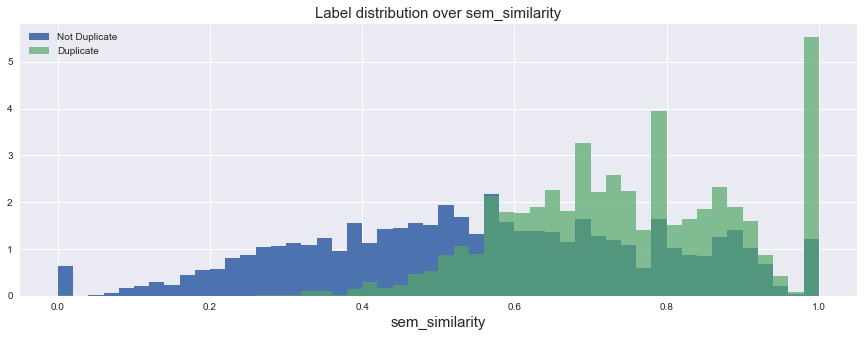

In [9]:
plt.figure(figsize=(15, 5))
train_word_match = trn['sem_similarity']
plt.hist(train_word_match[trn['is_duplicate'] == 0], bins=50, normed=True, label='Not Duplicate')
plt.hist(train_word_match[trn['is_duplicate'] == 1], bins=50, normed=True, alpha=0.7, label='Duplicate')
plt.legend()
plt.title('Label distribution over sem_similarity', fontsize=15)
plt.xlabel('sem_similarity', fontsize=15)

### Normalise question word counts and character lengths

In [10]:
##############################################################################
# Normalise features
##############################################################################

# normalise the word count for specific columns
norm_col = ['tr_q1WrdCnt',
            'tr_q2WrdCnt',
            'tr_q1Len',
            'tr_q2Len',
            'weight_q1_sw',
            'weight_q2_sw']

scaler = preprocessing.MinMaxScaler(feature_range=(0,1))
trn_scaled = pd.DataFrame(scaler.fit_transform(trn[norm_col]))
trn_scaled.columns = ['scaled_' + str(i) for i in trn_scaled.columns]

for i in trn_scaled.columns: trn[i] = trn_scaled[i].values

del trn_scaled

trn.head()

,tr_q1WrdCnt,tr_q2WrdCnt,tr_q1Len,tr_q2Len,wrdmatchpct,sem_similarity,word_order_similarity,weight_q1_sw,weight_q2_sw,weight_q1_mw,...,781,782,783,is_duplicate,scaled_0,scaled_1,scaled_2,scaled_3,scaled_4,scaled_5
0,8,12,35,51,0.72727,0.753482,0.600540,2.494043,2.808815,0.356292,...,0.45836,0.33885,0.33885,0,0.055118,0.045082,0.058140,0.044131,0.265610,0.221516
6,11,33,49,156,0.37037,0.564745,0.405881,2.553065,4.759111,0.364724,...,0.00000,0.00000,0.12707,0,0.078740,0.131148,0.081395,0.136805,0.271896,0.375325
12,13,19,68,104,0.26667,0.235702,0.331658,1.403321,3.211078,0.701660,...,0.00000,0.00000,0.27620,0,0.094488,0.073770,0.112957,0.090909,0.149451,0.253240
18,12,14,54,64,0.50000,0.725194,0.416087,2.551618,3.152514,0.364517,...,0.04777,0.68204,0.68204,1,0.086614,0.053279,0.089701,0.055605,0.271742,0.248621
24,17,17,85,97,0.40000,0.560983,0.706114,3.173274,3.559861,0.288479,...,0.13997,0.13997,0.11248,0,0.125984,0.065574,0.141196,0.084731,0.337947,0.280746


### Visualise word2vec similarity matrix

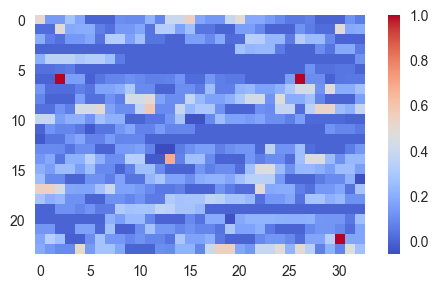

Is Duplicate: 0


In [11]:
cols = []
cols = list(trn.ix[:,trn.columns.get_loc('0'):(trn.columns.get_loc('783')+1)].columns)
cols.append('wrdmatchpct')
cols.append('sem_similarity')
cols.append('word_order_similarity')
#cols.append('scaled_0')
cols.append('scaled_1')
cols.append('scaled_2')
cols.append('scaled_3')
cols.append('scaled_4')
cols.append('scaled_5')

#cols = list(trn.ix[:,trn.columns.get_loc('tr_q1WrdCnt'):(trn.columns.get_loc('783')+1)].columns)
arr = trn.ix[1:1,cols], trn.ix[1:1,'is_duplicate']

# create matrix based on current dimension
img = np.resize(arr[0], (24, 33))

plt.figure(figsize=(5, 3), dpi=100)
disp = plt.imshow(img, interpolation='nearest', cmap=cm.coolwarm)
# make a color bar
plt.tight_layout()
plt.grid(False)
disp.axes.get_xaxis().set_visible(True)
disp.axes.get_yaxis().set_visible(True)
plt.colorbar(disp)
plt.show()

print('Is Duplicate: {0}'.format(arr[1].ix[1]))

## Building the CNN

This section details the steps to build the CNN. First we balance the data, prepare the target variable for classification and partition the data into training and validation set.

### Training Data Preparation

#### Oversample to balance the data

In [12]:
##############################################################################
# Negative / Positive cases oversampling to balance the data based on the testing set
##############################################################################

# Approx 36.9% are positive labels
pos_trn = trn[trn['is_duplicate'].values == 1]
neg_trn = trn[trn['is_duplicate'].values == 0]

# Now we oversample the negative class
# There is likely a much more elegant way to do this...
#p = 0.165
p = 0.22
scale = ((len(pos_trn) / (len(pos_trn) + len(neg_trn))) / p) - 1

while scale > 1:
    #neg_trn = pd.concat([neg_trn, neg_trn])
    pos_trn = pd.concat([pos_trn, pos_trn])
    scale -=1

#neg_trn = pd.concat([neg_trn, neg_trn[:int(scale * len(neg_trn))]])
pos_trn = pd.concat([pos_trn, pos_trn[:int(scale * len(pos_trn))]])
print('Proportion of positive training cases {0}'.format(len(pos_trn) / (len(pos_trn) + len(neg_trn))))


# separate features and labels based on the new training dataset
x_train = pd.concat([pos_trn, neg_trn])
y_train = (np.zeros(len(pos_trn)) + 1).tolist() + np.zeros(len(neg_trn)).tolist()

Proportion of positive training cases 0.49566256195633684


#### Apply One-Hot Encoding to Label (preparation for CNN)

In [13]:
##############################################################################
# Apply one hot encoding on the target variable
##############################################################################
# one hot encoding - sklearn.preprocessing.OneHotEncoder

enc = OneHotEncoder()
enc.fit(np.array(y_train).reshape(-1,1))  

x = pd.DataFrame(enc.transform(np.array(y_train).reshape(-1,1)).toarray())
y_train = pd.DataFrame(y_train, columns=['is_duplicate'])
y_train['is_dup_0'] = x[0].values
y_train['is_dup_1'] = x[1].values


# remove label columns from x_train. Don't change y_train as it is already the label list
x_train.drop(['is_duplicate'], axis=1, inplace = True)
#x_train.drop(['is_dup_0'], axis=1, inplace = True)
#x_train.drop(['is_dup_1'], axis=1, inplace = True)

# remove the old target variable now that we have one hot encoded the variable
y_train.drop(['is_duplicate'], axis=1, inplace = True)

y_train.head()

,is_dup_0,is_dup_1
0,0.0,1.0
1,0.0,1.0
2,0.0,1.0
3,0.0,1.0
4,0.0,1.0


#### Partition the data into training & validation sets

In [14]:
# training / test set split 80/20 based on random selection
# 4242, 12357
x_train, x_valid, y_train, y_valid = train_test_split(x_train,
                                                      y_train,
                                                      test_size = 0.2,
                                                      random_state = gs.seedvalue)

# free up 
del [pos_trn, neg_trn, x]

# garbage collection
gc.collect()

print('No. of training cases:{0}'.format(x_train.shape))
print('No. of validation cases:{0}'.format(x_valid.shape))

No. of training cases:(202239, 801)
No. of validation cases:(50560, 801)


### TensorFlow Modelling

#### Initialise variables

In [15]:
import tensorflow as tf
sess = tf.Session()

IMAGE_SIZE_X = 24
IMAGE_SIZE_Y = 33
NUM_CHANNELS = 1
SEED = 66478  # Set to None for random seed.
BATCH_SIZE = 250
NUM_EPOCHS = 20
EVAL_BATCH_SIZE = 250
EVAL_FREQUENCY = 100  # Number of steps between evaluations.
NUM_CLASSES = 2


#### Select features and assign training and validation data for tensorflow

In [16]:
# select features
includeCols = []
includeCols = list(x_train.ix[:,x_train.columns.get_loc('0'):(x_train.columns.get_loc('783')+1)].columns)
includeCols.append('wrdmatchpct')
includeCols.append('sem_similarity')
includeCols.append('word_order_similarity')
#includeCols.append('scaled_0')
includeCols.append('scaled_1')
includeCols.append('scaled_2')
includeCols.append('scaled_3')
includeCols.append('scaled_4')
includeCols.append('scaled_5')

# assign training and validation data for tensorflow
x_trndata = x_train.loc[:, includeCols]
y_trndata = pd.DataFrame(y_train)

x_validdata = x_valid.loc[:, includeCols]
y_validdata = pd.DataFrame(y_valid)

train_size = y_trndata.shape[0]

converter = np.array([0,1])

#### Setup variables and helper functions

In [17]:
with tf.name_scope('input'):
    # placeholder X serves as a target for feeds. It is not initialised and contains no data.
    # None to our placeholder, it means the placeholder can be fed as many examples
    # as you want to give it. In this case, our placeholder can be fed any multitude of
    # IMAGE_SIZE_X * IMAGE_SIZE_Y -sized values
    x = tf.placeholder(tf.float32, shape = [None, IMAGE_SIZE_X * IMAGE_SIZE_Y])

    # note that for the label is in the form of a vector of 2 floats
    y_ = tf.placeholder(tf.float32, shape = [None, NUM_CLASSES])


# good practice to initialize them with a slightly positive initial bias to avoid "dead neurons"
def weight_variable(shape):
    with tf.name_scope('weights'):
        initial = tf.truncated_normal(shape, stddev=0.05, seed=SEED, dtype=tf.float32)
        return tf.Variable(initial)


def bias_variable(shape):
    with tf.name_scope('bias'):
        initial = tf.constant(0.05, shape=shape)
        return tf.Variable(initial)


def conv2d(x, W):
    with tf.name_scope('conv2d'):
        return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')


def max_pool_2x2(x):
    with tf.name_scope('maxpool2x2'):
        return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')


# To apply the layer, we first reshape x to a 4d tensor, with the second and third
# dimensions corresponding to image width and height, and the final dimension corresponding
# to the number of color channels.
# -1 means that we take all the number of samples
# 28,28,1 means we reshape to a 28x28 matrix with 1 colour channel
x_image = tf.reshape(x, [-1,IMAGE_SIZE_X,IMAGE_SIZE_Y,1])

x_image

<tf.Tensor 'Reshape:0' shape=(?, 24, 33, 1) dtype=float32>

#### Create the first convolutional layer

In [18]:
# -----------------------------------------------------------------------------
# first convolutional layer
with tf.name_scope('layer_1'):
    W_conv1 = weight_variable([3, 3, 1, 32])
    b_conv1 = bias_variable([32])

    # convolve x_image with the weight tensor, add the bias, apply the ReLU function, and finally max pool
    h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)

    # The max_pool_2x2 method will reduce the image size to 14x14.
    h_pool1 = max_pool_2x2(h_conv1)

h_pool1

<tf.Tensor 'layer_1/maxpool2x2/MaxPool:0' shape=(?, 12, 17, 32) dtype=float32>

#### Create the second convolutional layer

Note that the pooling layer has reduced the matrix size by a factor of 2

In [19]:
# -----------------------------------------------------------------------------
# second convolutional layer
with tf.name_scope('layer_2'):
    W_conv2 = weight_variable([5, 5, 32, 64])
    b_conv2 = bias_variable([64])

    h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)

    # The max_pool_2x2 method will reduce the image size to 7x7.
    h_pool2 = max_pool_2x2(h_conv2)

h_pool2

<tf.Tensor 'layer_2/maxpool2x2/MaxPool:0' shape=(?, 6, 9, 64) dtype=float32>

#### Create the third convolutional layer (optional)

In [20]:
# -----------------------------------------------------------------------------
# third convolutional layer
with tf.name_scope('layer_3'):
    W_conv3 = weight_variable([5, 5, 64, 64])
    b_conv3 = bias_variable([64])

    h_conv3 = tf.nn.relu(conv2d(h_pool2, W_conv3) + b_conv3)

    # The max_pool_2x2 method will reduce the image size to 4x4.
    h_pool3 = max_pool_2x2(h_conv3)

h_pool3

<tf.Tensor 'layer_3/maxpool2x2/MaxPool:0' shape=(?, 3, 5, 64) dtype=float32>

#### Create fully connected layer, dropout and readout layer

In [21]:
# -----------------------------------------------------------------------------
# dense fully connected layer
with tf.name_scope('denselayer'):
    # we add a fully-connected layer with 1024 neurons to allow processing on the entire image
    W_fc1 = weight_variable([3 * 5 * 64, 960])
    b_fc1 = bias_variable([960])

    # We reshape the tensor from the pooling layer into a batch of vectors
    h_pool3_flat = tf.reshape(h_pool3, [-1, 3 * 5 * 64])

    # multiply by a weight matrix, add a bias, and apply a ReLU.
    h_fc1 = tf.nn.relu(tf.matmul(h_pool3_flat, W_fc1) + b_fc1)

h_fc1


# -----------------------------------------------------------------------------
# dropout layer
with tf.name_scope('dropout'):
    keep_prob = tf.placeholder(tf.float32)
    h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob, seed=SEED)

# -----------------------------------------------------------------------------
# readout layer
with tf.name_scope('readout'):
    W_fc2 = weight_variable([960, 2])
    b_fc2 = bias_variable([2])

    y_conv = tf.matmul(h_fc1_drop, W_fc2) + b_fc2

y_conv

<tf.Tensor 'readout/add:0' shape=(?, 2) dtype=float32>

#### Define loss function, regularizers, optimisers, evaluation functions

In [22]:
with tf.name_scope('cross_entropy'):
    # Training computation: logits + cross-entropy loss
    cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y_conv))

    # L2 regularization for the fully connected parameters.
    regularizers = (tf.nn.l2_loss(W_fc1) + tf.nn.l2_loss(b_fc1) +
                    tf.nn.l2_loss(W_fc2) + tf.nn.l2_loss(b_fc2))

    # Add the regularization term to the cross_entropy.
    cross_entropy += 5e-4 * regularizers


with tf.name_scope('train'):
    # Evaluate different optimizers
    # Optimizer: set up a variable that's incremented once per batch and controls the learning rate decay.
    batch = tf.Variable(0, dtype=tf.float32)

    # Decay once per epoch, using an exponential schedule starting at 0.01.
    learning_rate = tf.train.exponential_decay(0.005,                # Base learning rate
                                               batch * BATCH_SIZE,  # Current index into the dataset.
                                               train_size,          # Decay step.
                                               0.94,                # Decay rate.
                                               staircase=True)

    # Use simple momentum for the optimization.
    #train_step = tf.train.MomentumOptimizer(learning_rate, 0.9).minimize(cross_entropy, global_step=batch)
    #train_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(cross_entropy, global_step=batch)
    train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy, global_step=batch)


with tf.name_scope('evaluation'):
    # evaluation criteron
    correct_prediction = tf.equal(tf.argmax(y_conv,1), tf.argmax(y_,1))

    # calculate accuracy
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

accuracy

<tf.Tensor 'evaluation/Mean:0' shape=() dtype=float32>

#### Create Confusion Matrix and capture performance metrics

In [23]:
with tf.name_scope('confusionmatrix'):
    # Compute a per-batch confusion
    batch_confusion = tf.confusion_matrix(labels=tf.argmax(y_,1), predictions=tf.argmax(y_conv,1), num_classes=NUM_CLASSES)

    # Create an accumulator variable to hold the counts
    confusion = tf.Variable( tf.zeros([NUM_CLASSES, NUM_CLASSES], dtype=tf.int32 ), name='confusion' )
    
    # Create the update op for doing a "+=" accumulation on the batch
    confusion_update = confusion.assign(confusion + batch_confusion )

    # Cast counts to float so tf.summary.image renormalizes to [0,255] and using greyscale
    confusion_image = tf.reshape( tf.cast(confusion_update, tf.float32), [1, NUM_CLASSES, NUM_CLASSES, 1])

    # Count true positives, true negatives, false positives and false negatives.
    tp = tf.count_nonzero(tf.argmax(y_conv,1) * tf.argmax(y_,1))
    tn = tf.count_nonzero((tf.argmax(y_conv,1) - 1) * (tf.argmax(y_,1) - 1))
    fp = tf.count_nonzero(tf.argmax(y_conv,1) * (tf.argmax(y_,1) - 1))
    fn = tf.count_nonzero((tf.argmax(y_conv,1) - 1) * tf.argmax(y_,1))
        
    # Calculate accuracy, precision, recall and F1 score.
    #accuracy = (tp + tn) / (tp + fp + fn + tn)
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    fmeasure = (2 * precision * recall) / (precision + recall)
    
confusion_image

<tf.Tensor 'confusionmatrix/Reshape:0' shape=(1, 2, 2, 1) dtype=float32>

#### Create Summaries and initialise variables

In [ ]:
# Define summaries to display on tensorboard
# create a summary for our cost, accuracy and confusion matrix
# Add metrics to TensorBoard.    
tf.summary.scalar('Precision', precision)
tf.summary.scalar('Recall', recall)
tf.summary.scalar('f-measure', fmeasure)

tf.summary.scalar("Error Rate", cross_entropy)
tf.summary.scalar("Accuracy", accuracy)
tf.summary.image("Confusion", confusion_image)


# merge all summaries into a single "operation" which we can execute in a session 
summary_op = tf.summary.merge_all()

# create log writer object
writer = tf.summary.FileWriter("./log/qqp", graph=sess.graph)

# initialise variables
sess.run(tf.global_variables_initializer())


INFO:tensorflow:Summary name Error Rate is illegal; using Error_Rate instead.


#### Execute graph

In [ ]:
# Training model run
for step in range(int(NUM_EPOCHS * train_size) // BATCH_SIZE):
    # Compute the offset of the current minibatch in the data.
    # Note that we could use better randomization across epochs.
    offset = (step * BATCH_SIZE) % (train_size - BATCH_SIZE)
    batch_data = x_trndata.iloc[offset:(offset + BATCH_SIZE)]
    batch_labels = y_trndata.iloc[offset:(offset + BATCH_SIZE)]
    
    if step%(EVAL_FREQUENCY//10) == 0:
        #train_accuracy = accuracy.eval(session=sess, feed_dict={x:batch_data, y_: batch_labels, keep_prob: 1.0})
        #error = cross_entropy.eval(session=sess, feed_dict={x:batch_data, y_: batch_labels, keep_prob: 1.0})
        summary, train_accuracy, error, cm = sess.run([summary_op, accuracy, cross_entropy, confusion_update], feed_dict={x:batch_data, y_: batch_labels, keep_prob: 1.0})
        # write log every EVAL_FREQUENCY//10
        writer.add_summary(summary, step)
        
        # print every eval_frequency
        if step%(EVAL_FREQUENCY*10) == 0:
            print("step %d, training accuracy: %g error: %g"%(step, train_accuracy, error))

    train_step.run(session=sess, feed_dict={x: batch_data, y_: batch_labels, keep_prob: 0.5})

step 0, training accuracy: 0.5 error: 1.14947
step 1000, training accuracy: 0.668 error: 0.759565
step 2000, training accuracy: 0.688 error: 0.654401
step 3000, training accuracy: 0.74 error: 0.586773
step 4000, training accuracy: 0.744 error: 0.539394
step 5000, training accuracy: 0.74 error: 0.552331
step 6000, training accuracy: 0.776 error: 0.485238
step 7000, training accuracy: 0.772 error: 0.480766
step 8000, training accuracy: 0.764 error: 0.495129
step 9000, training accuracy: 0.744 error: 0.454493
step 10000, training accuracy: 0.796 error: 0.459333
step 11000, training accuracy: 0.784 error: 0.471421


Note: Execute Tensorboard as follows: tensorboard --logdir=run1:./log/qqp/ --port=6006 --host:127.0.0.1

#### Evaluate model with validation set

In [ ]:
# Validation of training model run
start = 0
end = 0

for i in range(1, round(len(x_validdata)/BATCH_SIZE)-1):
    #  batch = mnist.train.next_batch(50)
    start = end
    end = i*BATCH_SIZE
    batch = (np.array(x_validdata.iloc[start:end]), np.array(y_validdata.iloc[start:end]))
    
    if i%EVAL_FREQUENCY == 0:
        test_accuracy = accuracy.eval(session=sess, feed_dict={x:batch[0], y_: batch[1], keep_prob: 1.0})
        print("step %d, test accuracy %g"%(i, test_accuracy))

### CNN with SVM

In [ ]:
# define new batch size for faster processing
BATCH_SIZE = 500

converter = np.array([0,1])
train_features_cnn = np.zeros((train_size * NUM_EPOCHS, 960), dtype=float)
train_labels_cnn = np.zeros(train_size * NUM_EPOCHS, dtype=int)
test_labels_cnn = np.zeros(len(x_validdata), dtype=int)


for step in range(int(NUM_EPOCHS * train_size) // BATCH_SIZE):
    # Compute the offset of the current minibatch in the data.
    # Note that we could use better randomization across epochs.
    offset = (step * BATCH_SIZE) % (train_size - BATCH_SIZE)
    batch_data = x_trndata.iloc[offset:(offset + BATCH_SIZE)]
    batch_labels = y_trndata.iloc[offset:(offset + BATCH_SIZE)]
    
    #features_batch = h_fc1.eval(feed_dict={x: batch_data})
    features_batch = sess.run([h_fc1], feed_dict={x:batch_data, keep_prob: 1.0})
    labels_batch = batch_labels
    
    for j in range(BATCH_SIZE):
        for k in range(960):
            train_features_cnn[BATCH_SIZE * step + j, k] = features_batch[0][j, k]
        train_labels_cnn[BATCH_SIZE * step + j] = np.sum(np.multiply(converter, labels_batch.iloc[j,:]))

    if step%(EVAL_FREQUENCY*20) == 0:
        print('step {0} of {1}'.format(step, int(NUM_EPOCHS * train_size) // BATCH_SIZE))

In [ ]:
for i in range(1, round(len(x_validdata)/BATCH_SIZE)-1):
    #  batch = mnist.train.next_batch(50)
    start = end
    end = i*BATCH_SIZE
    batch = (np.array(x_validdata.iloc[start:end]), np.array(y_validdata.iloc[start:end]))
    
    test_features_cnn = h_fc1.eval(feed_dict={x: batch[0]})
    
    for j in range(BATCH_SIZE):
        test_labels_cnn[j] = np.sum(np.multiply(converter, y_validdata[j, :]))

In [ ]:
from sklearn import svm

# Using default parameters of SVM
clf = svm.SVC()
clf.fit(train_features_cnn, train_labels_cnn)

training_time = time.time()-initial_time
print("\nTraining Time = ", training_time)

accuracy = clf.score(test_features_cnn, test_labels_cnn)